## Import Libraries

In [1]:
from __future__ import print_function

import sys
import argparse
import importlib
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

from livelossplot import PlotLosses
import matplotlib.pyplot as plt

## Main Function and Utilities

In [5]:
def train(args, model, device, train_loader, optimizer, epoch, logs):
    model.train()
    # for livelossplot
    training_loss = 0.0
    training_corrects = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        # for livelossplot
        _, preds = torch.max(output, 1)
        training_loss += loss.detach() * data.size(0)
        training_corrects += torch.sum(preds == target.data)
        if batch_idx % args.log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.4f}%)]\tLoss: {loss.item():.6f}')
            if args.dry_run:
                break
    epoch_loss = training_loss / len(train_loader.dataset)
    epoch_acc = training_corrects.float() / len(train_loader.dataset)
    logs['log loss'] = epoch_loss.item()
    logs['accuracy'] = epoch_acc.item()


def test(model, device, test_loader, logs):
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.nll_loss(output, target)
            test_loss += loss.detach() * data.size(0)
            _, preds = torch.max(output, 1)
            test_corrects += torch.sum(preds == target.data)

    epoch_loss = test_loss / len(test_loader.dataset)
    epoch_acc = test_corrects.float() / len(test_loader.dataset)
    logs['val_log loss'] = epoch_loss.item()
    logs['val_accuracy'] = epoch_acc.item()
    print(f'\nTest set: Average loss: {epoch_loss:.4f}, Accuracy: {test_corrects}/{len(test_loader.dataset)} ({100. * epoch_acc:.4f}%)\n')


def show_wrong_prediction(model, device, test_loader, row=4, col=4, fig_size=(4, 4)):
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                results.append((
                    sample,
                    wrong_pred.item(),
                    actual_pred.item()))

        try:
            result_rnd = random.sample(results, row * col)
        except ValueError:
            result_rnd = results

        f, axarr = plt.subplots(row, col, figsize=(fig_size))
        for c in range(col):
            for r in range(row):
                if len(result_rnd) > 0:
                    result = result_rnd.pop()
                    axarr[r, c].imshow(result[0].cpu().numpy().squeeze(), cmap="gray_r")
                    axarr[r, c].set_title(f'{result[1]}({result[2]})')
                    axarr[r, c].axis('off')
        plt.tight_layout()
        plt.show()
        print(f'\nTest set prediction: {correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset):.0f}%)\n')


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('--net', type=str, default="ExampleNet",
                        help='File name of the network')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = datasets.MNIST('./data', train=True, download=True,
                              transform=transform)
    dataset2 = datasets.MNIST('./data', train=False,
                              transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    NetClass = globals().get(args.net) or getattr(importlib.import_module(args.net), args.net)
    model = NetClass().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    liveloss = PlotLosses()

    for epoch in range(1, args.epochs + 1):
        logs = {}
        train(args, model, device, train_loader, optimizer, epoch, logs)
        test(model, device, test_loader, logs)
        scheduler.step()
        liveloss.update(logs)
        liveloss.send()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        
    show_wrong_prediction(model, device, test_loader, 8, 8, (8,8))


## Define Networks

In [6]:
class ExampleNet(nn.Module):
    def __init__(self):
        super(ExampleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training

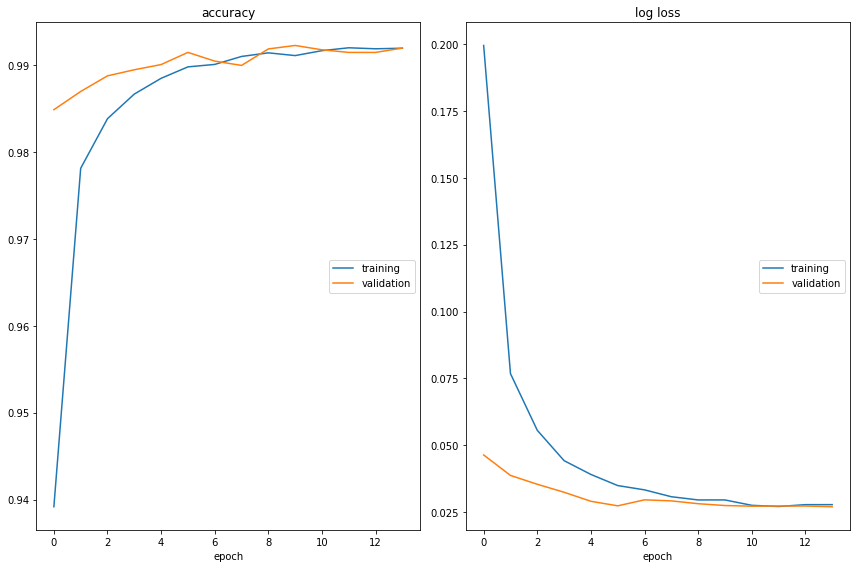

accuracy
	training         	 (min:    0.939, max:    0.992, cur:    0.992)
	validation       	 (min:    0.985, max:    0.992, cur:    0.992)
log loss
	training         	 (min:    0.027, max:    0.199, cur:    0.028)
	validation       	 (min:    0.027, max:    0.046, cur:    0.027)


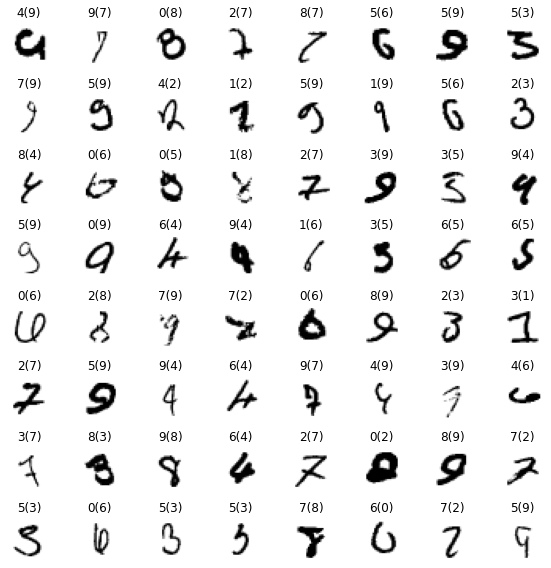


Test set prediction: 9920/10000 (99%)



In [7]:
sys.argv = ["", "--net=ExampleNet"]
main()